## Importations

In [26]:
import csv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
import nltk
import string
import re 
import unicodedata
from tqdm import tqdm
import unicodedata
from collections import defaultdict


## Data Loading

In [8]:


file_path_train = "data/train_submission.csv"
data_train = pd.read_csv(file_path_train)


In [17]:
data_train.head()

,Usage,Text,Label
0,Public,َ قَالَ النَّبِيُّ ص إِنِّي أَتَعَجَّبُ مِمَّن...,hau
1,Public,Filmen forteller historien om Will Hunting en...,nob
2,Public,An Arthrostylidium berryi in uska species han ...,wln
3,Public,Kancunarí enemigosniyquichejta munacuychej al...,quh
4,Public,Warmeqa ama yachachichunchu hermanospa tantaku...,quh


In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190599 entries, 0 to 190598
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Usage   190599 non-null  object
 1   Text    190599 non-null  object
 2   Label   190099 non-null  object
dtypes: object(3)
memory usage: 4.4+ MB


# Data Overview


## First, let's examine the unlabeled data.


We should check for any missing values in the dataset, as handling them is crucial for accurate analysis and modeling. Any missing data needs to be addressed, either by removing the affected rows or imputing the missing values

In [9]:
data_train_without_label = data_train[data_train["Label"].isna()]

In [10]:
data_train_without_label

,Usage,Text,Label
107,Public,Kòe bô jōa kú hō͘-sū sió-chiá lâi kā góan mn̄...,NaN
803,Public,Söğütçük sī chi̍t ê tī Türkiye Aydın séng Çine...,NaN
1095,Public,Golden Valley Kūn ū khó-lêng sī kóng:,NaN
1894,Public,Tī Montégut-Lauragais ê sì-ûi ū Nogaret Revel...,NaN
2499,Public,Soveria Simeri ùi séng lāi ê hoān-ûi.,NaN
...,...,...,...
189637,Public,Bellebrune sī ūi-tī Hoat-kok Nord-Pas-de-Calai...,NaN
189946,Public,Bô phah-sǹg tī sin-le̍k 10 go̍eh 29 hō ē-po͘ ...,NaN
189959,Public,Wiejki sī chi̍t ê tī Pho-lân Kiōng-hô-kok Podl...,NaN
190397,Public,Tī pún só͘-chāi sì-ûi ê tē-hng ū Valy Veselí ...,NaN


There are **500** instances that are unlabeled.

We choose to remove these instances for the training of our models.

In [11]:
data_train_without_nan_for_label = data_train.dropna() # suppression des données non labellisées

## Analysis of Labeled Data

Next, we analyze the labeled data to better understand the distribution and characteristics of each language in the dataset. This step involves examining the frequency of each language, checking for imbalances, and identifying any patterns that might inform our model.

In [12]:
number_of_languages = len(data_train["Label"].unique())
print(f"Il y a {number_of_languages} différentes langues dans le dataset de train")

Il y a 390 différentes langues dans le dataset de train


In [13]:
dataset_sorted_by_number_instances_by_language = data_train_without_nan_for_label.groupby("Label").count().sort_values('Usage', ascending=True)
dataset_sorted_by_number_instances_by_language.head()

,Usage,Text
Label,,
gcr,1,1
gaa,1,1
toi,1,1
kua,1,1
gil,2,2


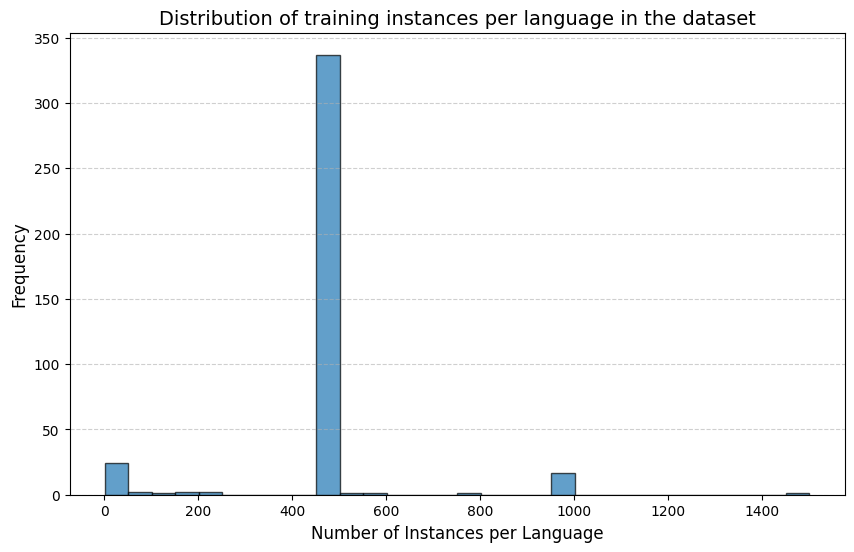

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(dataset_sorted_by_number_instances_by_language['Text'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Instances per Language", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of training instances per language in the dataset", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

In [15]:
#Underrepresented languages
df = dataset_sorted_by_number_instances_by_language
underrepresented_languages = list(df[df['Text']<10].index)

We observe that the number of examples per language varies. Some languages are overrepresented, with the first language having 1500 instances, compared to others.

In [16]:
percentage_of_languages_with_at_least_100_instances = len(dataset_sorted_by_number_instances_by_language[dataset_sorted_by_number_instances_by_language["Usage"] >= 100])/len(dataset_sorted_by_number_instances_by_language) * 100
print(f"Le pourcentage de langues avec au moins 100 instances est {percentage_of_languages_with_at_least_100_instances}%")

Le pourcentage de langues avec au moins 100 instances est 93.31619537275064%


The percentage of languages with at least 100 instances is 93.32%
--> This indicates that a large majority of the languages in the dataset have a sufficient number of instances, with over 93% of the languages having 100 or more examples

 #  Data Preprocessing 

In [7]:

def cleaning(text): 
    """
    Fonction pour pré-traiter le texte en enlevant tous les éléments de ponctuation, les chiffres, les double espaces, les URL etc. 
    """

    if not isinstance(text, str):
        return ""

    # text = re.sub(r"\(.*?\)|\[.*?\]|\{.*?\}|['\"«»„“”‘’]|\<.*?\>", " ", text) # 1. Supprimer les textes entre (), [], {}, "", « »
    text = re.sub(r"https?://[^\s]+|www\.[^\s]+", " ", text) # Supprimer les URLs
    # text = re.sub(r"\b[A-ZÀ-ÖØ-Þ][a-zà-öø-ÿ]*", " ", text) # Supprimer les mots qui commencent par une majuscule (prénoms, noms propres, etc.)
    # text = re.sub(r"\b[A-Z]+\d*[A-Z\d]*", " ", text) # Supprimer les sigles type "IK10", "ABC123", "X4D" (au moins 1 lettre + au moins 1 chiffre)
    text = re.sub(r"\d+", " ", text)  # Supprimer les nombres isolés
    text = text.translate(str.maketrans("", "", string.punctuation))  # Supprimer la ponctuation et les caractères spéciaux
    # text = ''.join(c for c in text if unicodedata.category(c)[0] not in ["C", "S"])  # Supprimer les caractères de contrôle Unicode, symboles et emojis
    text = ''.join(c for c in text if not (unicodedata.category(c).startswith('P') or unicodedata.category(c) in ['No']))

    asian_punctuation = "，。？！《》【】（）；：、。•" # Liste de ponctuation à inclure pour les langues asiatiques
    text = re.sub(r'[\-\u2010-\u2015]', '', text) # supprime tous les types de tirets
    text = re.sub(r"['\"‘’‚‛“”„‟‹›«»⹂⹃⸂⸃⸄⸅⸉⸊「」『』〝〞＂ˮ`´ʹʺʻʼʽʾʿˈˊˋ]", '', text)

    # text = text.translate(str.maketrans('', '', string.punctuation + asian_punctuation)) # supprime la ponctuation asiatique
    text = re.sub(r"\s+", " ", text).strip() # enlève les double espaces

    text_cleaned = text.lower() # met le texte en minuscule 

    return(text_cleaned)


We have decided not to remove the text within (), [], {}, "", and « » as we noticed that doing so leads to worse results. This approach causes us to lose valuable information.

## Creating an English Word Set to Remove English Words from Mixed-Language Sentences

We will create a set of English words to remove any English words from sentences that contain a mix of English and other languages. This helps in reducing noise and ensures that the model focuses more on the non-English parts of the text, especially in multilingual sentences

In [10]:
import nltk
from nltk.corpus import words

# Télécharger la liste des mots en anglais (une seule fois nécessaire)
nltk.download('words')

# Liste des mots en anglais
english_words = set(word.lower() for word in words.words())


[nltk_data] Downloading package words to
[nltk_data]     /Users/hippolytelecomte/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
data_ang = data_train_without_nan_for_label[data_train_without_nan_for_label["Label"] == 'eng']["Text"]

# Collecte des mots uniques
for text in data_ang:
    for word in text.split():
        english_words.add(word.lower())

In [12]:
def remove_most_english_words(text): 
    """
    Fonction pour enlever les mots anglais lorsque la langue du texte n'est pas l'anglais. 
    """
    tokens = text.split() 
    filtered_tokens = [word for word in tokens if word.lower() not in english_words]

    return ' '.join(filtered_tokens)

Finally, we realize that removing English words from sentences that are not labeled as English reduces our results. This suggests that removing English words from mixed-language sentences may lead to the loss of valuable context, ultimately negatively impacting model performance. Therefore, we decide to retain these words for better accuracy.

In [8]:
tqdm.pandas()  

def pre_processing(df, remove_espace = True, not_test = True, need_to_clean = True): 
    """
    Utilisation des méthodes de pré-traitement définies auparavant pour rendre le texte propre. 
    """

    if need_to_clean: 
        df['Text'] = df['Text'].apply(cleaning)
    
    if not_test: 
        df['Text'] = df.progress_apply(
            lambda row: remove_most_english_words(row['Text']) if row['Label'] != 'eng' else row['Text'], axis=1
        )
    
    if remove_espace: 
        df['Text'] = df['Text'].str.replace(' ', '', regex=False)
    
    return df


We also notice that in the training dataset, there are languages that can be written in different alphabets, especially for some Asian languages. We decide to create a function that detects the alphabets present in the sentence and determines the majority alphabet based on the number of characters (although this method is not optimal, as some alphabets contain more information in their characters than others). Afterward, we update the label of the sentences by adding the alphabet used for the language, thus creating new categories such as "fra_Latin" for French written with the Latin alphabet.

In [9]:
# Catégorisation fine des scripts
SCRIPT_MAP = {
    "LATIN": "Latin",
    "CYRILLIC": "Cyrillique",
    "ARABIC": "Arabe",
    "HEBREW": "Hébreu",
    "GREEK": "Grec",
    "DEVANAGARI": "Devanagari (Hindi, Sanskrit)",
    "HIRAGANA": "Hiragana (Japonais)",
    "KATAKANA": "Katakana (Japonais)",
    "CJK": "Kanji (Chinois, Japonais, Coréen)",
    "HANGUL": "Hangul (Coréen)",
    "THAI": "Thaï",
    "ARMENIAN": "Arménien",
    "GEORGIAN": "Géorgien",
    "ETHIOPIC": "Éthiopien",
    "TAMIL": "Tamoul",
    "BENGALI": "Bengali",
    "TELUGU": "Télougou",
}

def count_alphabet_characters(text):
    script_counts = defaultdict(int)

    for char in text:
        if char.isalpha():  # On ignore les symboles et ponctuations
            try:
                char_name = unicodedata.name(char) 
                script_key = char_name.split()[0]  # Prend le premier mot du nom Unicode
                
                if "CJK" in char_name:
                    script_key = "CJK"  # Les kanji sont classés sous "CJK UNIFIED IDEOGRAPH"
                
                script_name = SCRIPT_MAP.get(script_key, script_key)  # Utilise le mapping o
                script_counts[script_name] += 1  # Incrémente le compteur
                
            except ValueError:
                continue  # Si le caractère n'a pas de nom Unicode
    
    return dict(script_counts)  # Retourne un dictionnaire des comptages

def most_frequent_script(text):
    script_counts = count_alphabet_characters(text)  # Appel de la fonction précédente
    
    if script_counts:  # Vérifie si le dictionnaire n'est pas vide
        most_common_script = max(script_counts.items(), key=lambda x: x[1])  # Trouve l'alphabet avec le max de caractères
        return most_common_script  # Retourne (nom de l'alphabet, nombre d'occurrences)
    else:
        return None  # Retourne None si aucun alphabet trouvé

from tqdm import tqdm

def add_alphabet_to_label(df):
    for index, row in tqdm(df.iterrows(), total=len(df)):  # Parcourt chaque ligne du DataFrame
        alphabet_most_frequent = most_frequent_script(row['Text'])  # Détecte l'alphabet dominant
        
        if alphabet_most_frequent:  # Vérifie si un alphabet a été trouvé
            df.at[index, 'Label'] = f"{row['Label']}_{alphabet_most_frequent[0]}"  # Met à jour le label
    
    return df


In [ ]:

def restore_original_label(label):
    return label.split("_")[0]  # Prend seulement la première partie avant '_'

def restore_labels(liste):
    new_liste = []
    for element in tqdm(liste): 
        new_liste.append(restore_original_label(element))
    return np.array(new_liste)